# Models: Linear, Logistic, Random Forest

In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Libraries

In [3]:
import numpy as np
import pandas as pd

# import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf 
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

import zipfile

### Read, Split, and Standardize Data

In [13]:
temp = pd.read_csv('data/preprocessed.csv')
df = pd.read_csv('data/preprocessed.csv')

datetimes = pd.to_datetime(df['created_at'])
df['year'] = [i.year for i in datetimes]
df['month'] = [i.month for i in datetimes]
df['day'] = [i.day for i in datetimes]
df['hour'] = [i.hour for i in datetimes]

df = df.drop(['stock_dif', 'Unnamed: 0', 'text', 'created_at', 'preproc', 'keywords', 'is_retweet','äôs', 'äôt', 'äù', 'üá'], axis = 1)

X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'stock_up'], 
                                                         df.stock_up, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.stock_up)
index = X_test.index

In [14]:
# Standardize the data
standard_scaler = StandardScaler()
x_fitted_scaler = standard_scaler.fit(X_train)
x_train_transform = x_fitted_scaler.transform(X_train)
x_test_transform = x_fitted_scaler.transform(X_test)
X_train = pd.DataFrame(x_train_transform, columns = X_train.columns)
X_test = pd.DataFrame(x_test_transform, columns = X_test.columns)

C:\Users\sw708\Miniconda3\envs\sams_env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\sw708\Miniconda3\envs\sams_env\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\sw708\Miniconda3\envs\sams_env\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


<div class='theme'> Linear Regression Model </div>

#### Linear Model

In [15]:
lm = LinearRegression().fit(X_train, y_train)
lm_pred_tr = lm.predict(X_train)
lm_pred_test = lm.predict(X_test)
lm_score_tr = accuracy_score(y_train,[int(round(i)) for i in lm_pred_tr])*100
lm_score_test = accuracy_score(y_test, [int(round(i)) for i in lm_pred_test])*100
print("Linear Model Training Set Accuracy:",str(lm_score_tr)+'%')
print("Linear Model Testing Set Accuracy:",str(lm_score_test)+'%')                  

Linear Model Training Set Accuracy: 59.9370945547474%
Linear Model Testing Set Accuracy: 55.503144654088054%


<div class='theme'> Multiple Logistic Regression Model </div>

#### Simple Multiple Logistic Model

In [16]:
#Training
log_model = LogisticRegression(C=100000).fit(X_train, y_train)
#Predict
y_tr_pred = log_model.predict(X_train)
y_test_pred = log_model.predict(X_test)
#Performance Evaluation
tr_score_log = accuracy_score(y_train, y_tr_pred)*100
test_score_log = accuracy_score(y_test, y_test_pred)*100

print("Simple Logistic Model Training Set Accuracy:",str(tr_score_log)+'%')
print("Simple Logistic Model Testing Set Accuracy:",str(test_score_log)+'%')

C:\Users\sw708\Miniconda3\envs\sams_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Simple Logistic Model Training Set Accuracy: 59.89777865146452%
Simple Logistic Model Testing Set Accuracy: 55.42452830188679%


Text(0.5, 0, 'Probability')

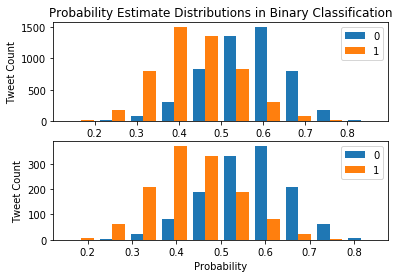

In [8]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.set_title('Probability Estimate Distributions in Binary Classification')
ax1.hist(log_model.predict_proba(X_train), label = ['0', '1'])
ax2.hist(log_model.predict_proba(X_test), label = ['0', '1'])
ax1.legend()
ax2.legend()
ax1.set_ylabel('Tweet Count')
ax2.set_ylabel('Tweet Count')
ax2.set_xlabel('Probability')

#### Regularized Multiple Logistic Model

In [17]:
log_model_cv = LogisticRegressionCV(penalty = 'l1', solver = 'liblinear', max_iter = 10000).fit(X_train, y_train)
#Predict
y_pred_cv = log_model_cv.predict(X_train)
y_pred_test_cv = log_model_cv.predict(X_test)
#Performance Evaluation
tr_score_cv = accuracy_score(y_train, y_pred_cv)*100
test_score_cv = accuracy_score(y_test, y_pred_test_cv)*100

print("Regularized Logistic Model Training Set Accuracy:",str(tr_score_cv)+'%')
print("Regularized Logistic Model Testing Set Accuracy:",str(test_score_cv)+'%')

C:\Users\sw708\Miniconda3\envs\sams_env\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Regularized Logistic Model Training Set Accuracy: 56.536268920778454%
Regularized Logistic Model Testing Set Accuracy: 56.5251572327044%


Text(0.5, 0, 'Probability')

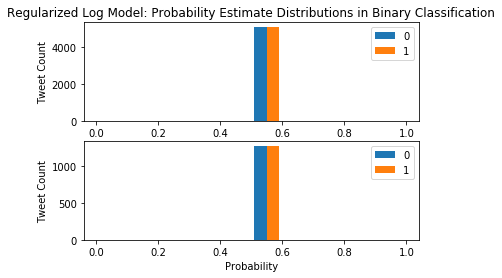

In [41]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.set_title('Regularized Log Model: Probability Estimate Distributions in Binary Classification')
ax1.hist(log_model_cv.predict_proba(X_train), label = ['0', '1'])
ax2.hist(log_model_cv.predict_proba(X_test), label = ['0', '1'])
ax1.legend()
ax2.legend()
ax1.set_ylabel('Tweet Count')
ax2.set_ylabel('Tweet Count')
ax2.set_xlabel('Probability')

<div class='theme'> Random Forest Model </div>

##### Finding the Best Depth for Random Forest Classifier

In [42]:
def calc_meanstd(X_train, y_train, depths):
    train_scores = {}
    cvmeans = {}
    cvstds = {}
    for depth in depths:
        model = DecisionTreeClassifier(max_depth = depth)
        score = cross_val_score(estimator=model, X = X_train, y = y_train, cv=5, n_jobs = -1)
        train_scores[depth] = score
        cvmeans[depth] = score.mean()
        cvstds[depth] = score.std()
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths = list(range(1,51)))
best_depth = max(cvmeans, key=cvmeans.get)

#### Random Forest Model

In [18]:
rf_model = RandomForestClassifier(n_estimators = 50, max_depth = 6, max_features = 'sqrt').fit(X_train, y_train)
random_forest_test_score = accuracy_score(y_test, rf_model.predict(X_test))*100
random_forest_train_score = accuracy_score(y_train, rf_model.predict(X_train))*100
print('Random Forest Model Training Accuracy Score: ', random_forest_train_score, '%')
print('Random Forest Model Testing Accuracy Score: ', random_forest_test_score, '%')

Random Forest Model Training Accuracy Score:  65.18576764301159 %
Random Forest Model Testing Accuracy Score:  57.311320754716974 %


##### Visualization

In [46]:
def graph_acc(depth):
    testing = {}
    training = {}
    for i in range(depth):
        rf = RandomForestClassifier(n_estimators = 50, max_depth = i+1, max_features = 'sqrt').fit(X_train, y_train)
        training[i] = accuracy_score(y_train, rf.predict(X_train))
        testing[i] = accuracy_score(y_test, rf.predict(X_test))
    return training, testing
tr_list, test_list = graph_acc(10)

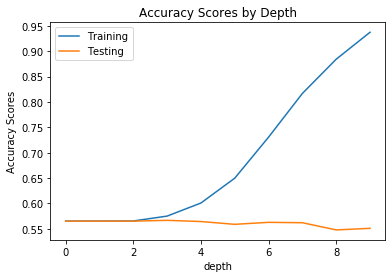

In [47]:
plt.figure()
plt.title('Accuracy Scores by Depth')
plt.xlabel('depth')
plt.ylabel('Accuracy Scores')
plt.plot(*zip(*sorted(tr_list.items())), label = 'Training')
plt.plot(*zip(*sorted(test_list.items())), label = 'Testing')
plt.legend(loc = 'upper left')
plt.show()

Text(0.5, 0, 'Probability')

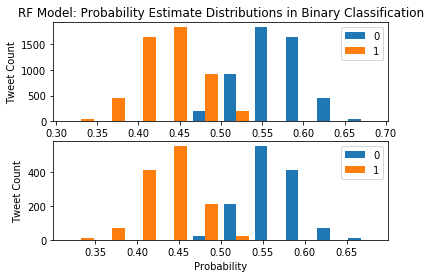

In [48]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.set_title('RF Model: Probability Estimate Distributions in Binary Classification')
ax1.hist(rf_model.predict_proba(X_train), label = ['0', '1'])
ax2.hist(rf_model.predict_proba(X_test), label = ['0', '1'])
ax1.legend()
ax2.legend()
ax1.set_ylabel('Tweet Count')
ax2.set_ylabel('Tweet Count')
ax2.set_xlabel('Probability')

In [33]:
predictions = pd.DataFrame(rf_model.predict(X_test), index = index)
dates = pd.DataFrame(datetimes[index], index = index)
rf_prediction = pd.concat([predictions, dates], axis = 1)
rf_prediction.to_csv('data/rf_prediction')

(array([  60,  144,  168,  232,  233,  274,  316,  324,  348,  377,  398,
         422,  458,  570,  577,  587,  604,  657,  755,  760,  792,  797,
         816,  821,  833,  855,  858,  873,  906,  912,  943, 1054, 1074,
        1086, 1106, 1134, 1205, 1210, 1233, 1263], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64))

##### Most important features from Random Forest Model

In [49]:
feature_list = dict(zip(X_train.columns.values, rf_model.feature_importances_))
top_10_features = sorted(feature_list, key = feature_list.get, reverse = True)[:10]
top_10_features

['usa',
 'coming',
 'collusion',
 'retweet_count',
 'border',
 'meeting',
 'really',
 'republican',
 'security',
 'favorite_count']

<div class='theme'> Neural Network </div>

In [21]:
model = Sequential()
model.add(Dense(16, input_shape = (152,), activation = 'relu'))
model.add(Dense(32, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(.6))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam',loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
hist = model.fit(X_train, y_train, validation_split = .2, batch_size = 32, epochs = 50)

Train on 4069 samples, validate on 1018 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
4069/4069 [==============================] - 1s 211us/sample - loss: 0.9204 - acc: 0.5114 - val_loss: 0.8238 - val_acc: 0.5285
Epoch 2/50
4069/4069 [==============================] - 0s 64us/sample - loss: 0.8125 - acc: 0.5367 - val_loss: 0.7806 - val_acc: 0.5432
Epoch 3/50
4069/4069 [==============================] - 0s 64us/sample - loss: 0.7630 - acc: 0.5625 - val_loss: 0.7541 - val_acc: 0.5422
Epoch 4/50
4069/4069 [==============================] - 0s 62us/sample - loss: 0.7409 - acc: 0.5616 - val_loss: 0.7360 - val_acc: 0.5501
Epoch 5/50
4069/4069 [==============================] - 0s 64us/sample - loss: 0.7243 - acc: 0.5630 - val_loss: 0.7235 - val_acc: 0.5550
Epoch 6/50
4069/4069 [==============================] - 0s 62us/sample - loss: 0.7089 - acc: 0.5721 - val_loss: 0.7155 - val_acc: 0.5530
Epoch 7/50
4069/4069 [==============================] - 0s 64us/sample - loss: 0.

##### Visualization

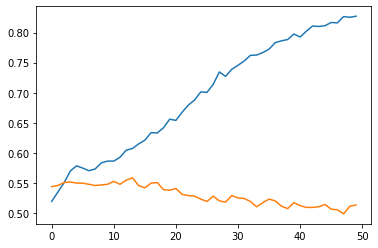

In [52]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

##### Neural Network Results

In [27]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)
prediction = pd.DataFrame(predictions_test, index = X_test.index)
dates = temp.iloc[X_test.index]['created_at']
neural_predict = pd.concat([prediction, dates], axis = 1)
neural_predict.to_csv('data/neural_prediction')

In [56]:
predict_tr = [1 if x > .9 else 0 for x in predictions_train]
predict_test = [1 if x > .9 else 0 for x in predictions_test]
nn_tr_score = accuracy_score(y_train, predict_tr)*100
nn_test_score = accuracy_score(y_test, predict_test)*100
index = np.where(prediction[0] > .9)[0]
# top_tweet = temp.iloc[np.where(prediction[0] > .90)]['text'][488]
# print('tweet that would raise stock market is: ', top_tweet)
# worst_tweet = temp.iloc[np.where(prediction[0] < .01)]['text'][899]
# print('tweet that would lower stock market is: ', worst_tweet)

# Model Results

In [57]:
names = []
scores = []
scores.append([[lm_score_tr, lm_score_test], [tr_score_log, test_score_log],
               [tr_score_cv, test_score_cv], [random_forest_train_score, random_forest_test_score], [nn_tr_score, nn_test_score]])
names.append(['Linear Regression', 'Simple Logistic', 'Regularized Logistic', 'Random Forest', 'Neural Network'])
results_df = pd.DataFrame(scores[0], index = names[0], columns = ['Training Accuracy (%)', 'Testing Accuracy (%)'])
results_df

,Training Accuracy (%),Testing Accuracy (%)
Linear Regression,59.209750,54.481132
Simple Logistic,59.327698,54.559748
Regularized Logistic,56.536269,56.525157
Random Forest,60.723413,56.839623
Neural Network,61.568705,56.525157
